# Simulation in CASA

Original Author: rurvashi@aoc.nrao.edu



## Description

Get creative with data sets to be used for test scripts and characterization of numerical features/changes. This notebook goes beneath the simobserve task and illustrates simple ways in which developers and test writers can make full use of the flexibility offered by our tools and the imager framework. It also exercises some usage modes that our users regularly encounter and exposes some quirks of our scripting interface(s). Rudimentary image and data display routines are included below.

__Topics Covered below__

    - Install CASA 6 and Import required libraries
    
    - Make an empty MS with the desired sub-structure
    - Make a true sky model
    - Predict visibilities onto the DATA column of the MS
    - Add noise and other errors
    
    - A few example use cases
        - Image one channel
        - Cube imaging with a spectral line
        - Continuum wideband imaging with model subtraction
        - Self-calibration and imaging
        
     - Ideas for CASA developers and test writers to do beyond these examples.


## Installation

__Option 1 : Install local python3__

```
export PPY=`which python3`
virtualenv -p $PPY --setuptools ./local_python3
./local_python3/bin/pip install --upgrade pip
./local_python3/bin/pip install --upgrade numpy matplotlib ipython astropy
./local_python3/bin/pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatools
./local_python3/bin/pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatasks
./local_python3/bin/pip3 install jupyter
```

__Option 2 : Install at runtime__ (for Google Colab)



In [1]:
import os

print("installing pre-requisite packages...")
os.system("apt-get install libgfortran3")

print("installing casa...")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks==6.2.0.106")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casadata")
print("complete")


installing pre-requisite packages...
installing casa...
complete


__Import Libraries__

In [2]:
# Import required tools/tasks
from casatools import simulator, image, table, coordsys, measures, componentlist, quanta, ctsys
from casatasks import tclean, ft, imhead, listobs, exportfits, flagdata, bandpass, applycal
from casatasks.private import simutil

import os
import pylab as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


# Instantiate all the required tools
sm = simulator()
ia = image()
tb = table()
cs = coordsys()
me = measures()
qa = quanta()
cl = componentlist()
mysu = simutil.simutil()

## Make an empty MS with the desired uvw/scan/field/ddid setup

Construct an empty Measurement Set that has the desired observation setup. 
        This includes antenna configuration, phase center direction, spectral windows, 
        date and timerange of the observation, structure of scans/spws/obsidd/fieldids 
        (and all other MS metadata). Evaluate UVW coordinates for the entire observation 
        and initialize the DATA column to zero.
       
__Methods__

__Make an empty MS__

In [3]:
def makeMSFrame(msname = 'sim_data.ms'):
    """ 
    Construct an empty Measurement Set that has the desired observation setup. 
    """
        
    os.system('rm -rf '+msname)
        
    ## Open the simulator
    sm.open(ms=msname);

    ## Read/create an antenna configuration. 
    ## Canned antenna config text files are located here : /home/casa/data/trunk/alma/simmos/*cfg
    antennalist = os.path.join( ctsys.resolve("alma/simmos") ,"vla.d.cfg")   
    
    ## Fictitious telescopes can be simulated by specifying x, y, z, d, an, telname, antpos.
    ##     x,y,z are locations in meters in ITRF (Earth centered) coordinates. 
    ##     d, an are lists of antenna diameter and name.
    ##     telname and obspos are the name and coordinates of the observatory. 
    (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)

    ## Set the antenna configuration
    sm.setconfig(telescopename=telname,
                     x=x,
                     y=y,
                     z=z,
                     dishdiameter=d,
                     mount=['alt-az'], 
                     antname=an,
                     coordsystem='global',
                     referencelocation=me.observatory(telname));

    ## Set the polarization mode (this goes to the FEED subtable)
    sm.setfeed(mode='perfect R L', pol=['']);

    ## Set the spectral window and polarization (one data-description-id). 
    ## Call multiple times with different names for multiple SPWs or pol setups.
    sm.setspwindow(spwname="LBand",
                   freq='1.0GHz',
                   deltafreq='0.1GHz',
                   freqresolution='0.2GHz',
                   nchannels=10,
                   stokes='RR LL');

    ## Setup source/field information (i.e. where the observation phase center is)
    ## Call multiple times for different pointings or source locations.
    sm.setfield( sourcename="fake",
                 sourcedirection=me.direction(rf='J2000', v0='19h59m28.5s',v1='+40d44m01.5s'));

    ## Set shadow/elevation limits (if you care). These set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='1deg');

    ## Leave autocorrelations out of the MS.
    sm.setauto(autocorrwt=0.0);  

    ## Set the integration time, and the convention to use for timerange specification
    ## Note : It is convenient to pick the hourangle mode as all times specified in sm.observe()
    ##        will be relative to when the source transits.
    sm.settimes(integrationtime='2000s', 
                usehourangle=True,
                referencetime=me.epoch('UTC','2019/10/4/00:00:00'));

    ## Construct MS metadata and UVW values for one scan and ddid 
    ## Call multiple times for multiple scans.
    ## Call this with different sourcenames (fields) and spw/pol settings as defined above.
    ## Timesteps will be defined in intervals of 'integrationtime', between starttime and stoptime.
    sm.observe(sourcename="fake",
               spwname='LBand', 
               starttime='-5.0h', 
               stoptime='+5.0h');

    ## Close the simulator
    sm.close()
    
    ## Unflag everything (unless you care about elevation/shadow flags)
    flagdata(vis=msname,mode='unflag')

__Plot columns of the MS__

In [4]:
def plotData(msname='sim_data.ms', myplot='uv'):
    """
    Options : myplot='uv'
              myplot='data_spectrum'
    """
    from matplotlib.collections import LineCollection
    tb.open(msname)

    # UV coverage plot
    if myplot=='uv':
        pl.figure(figsize=(4,4))
        pl.clf()
        uvw = tb.getcol('UVW')
        pl.plot( uvw[0], uvw[1], '.')
        pl.plot( -uvw[0], -uvw[1], '.')
        pl.title('UV Coverage')
    
    # Spectrum of chosen column. Make a linecollection out of each row in the MS.
    if myplot=='data_spectrum' or myplot=='corr_spectrum' or myplot=='resdata_spectrum'  or myplot=='rescorr_spectrum' or myplot=='model_spectrum':
        dats=None
        if myplot=='data_spectrum':
            dats = tb.getcol('DATA')
        if myplot=='corr_spectrum':
            dats = tb.getcol('CORRECTED_DATA')
        if myplot=='resdata_spectrum':
            dats = tb.getcol('DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='rescorr_spectrum':
            dats = tb.getcol('CORRECTED_DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='model_spectrum':
            dats = tb.getcol('MODEL_DATA')
            
        xs = np.zeros((dats.shape[2],dats.shape[1]),'int')
        for chan in range(0,dats.shape[1]):
            xs[:,chan] = chan
    
        npl = dats.shape[0]
        fig, ax = pl.subplots(1,npl,figsize=(10,4))
        
        for pol in range(0,dats.shape[0]):
            x = xs
            y = np.abs(dats[pol,:,:]).T
            data = np.stack(( x,y ), axis=2)
            ax[pol].add_collection(LineCollection(data))
            ax[pol].set_title(myplot + ' \n pol '+str(pol))
            ax[pol].set_xlim(x.min(), x.max())
            ax[pol].set_ylim(y.min(), y.max())
        pl.show()
    
    tb.close()


__Examples__

Make a Measurement Set and inspect it

In [5]:
makeMSFrame()

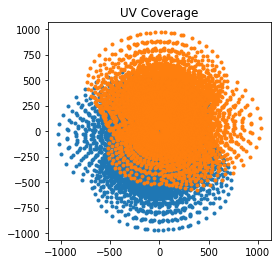

In [6]:
plotData(myplot='uv')

In [7]:
listobs(vis='sim_data.ms', listfile='obslist.txt', verbose=False, overwrite=True)
## print(os.popen('obslist.txt').read()) # ?permission denied?
fp = open('obslist.txt')
for aline in fp.readlines():
    print(aline.replace('\n',''))
fp.close()

           MeasurementSet Name:  /content/sim_data.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: VLA(27 antennas)
Data records: 6318       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2019/21:21:40.2   to   04-Oct-2019/07:21:40.2 (UTC)

Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake                19:59:28.500000 +40.44.01.50000 J2000   0           6318
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      LBand     10   TOPO    1000.000    100000.000   1000000.0   1450.0000   RR  LL
Antennas: 27 'name'='station' 
   ID=   0-5: 'W01'='P', 'W02'='P', 'W03'='P', 'W04'='P', 'W05'='P', 'W06'='P', 
   ID=  6-11: 'W07'='P', 'W08'='P', 'W09'='P', 'E01'='P', 'E02'='P', 'E03'='P', 
   ID= 12-17: 'E04'='P', 'E05'='P', 'E06'='P', 'E07'='P', 'E0

## Make a True Sky Model (component list and/or image) 

Construct a true sky model for which visibilities will be simulated and stored in the DATA column. This could be a component list (with real-world positions and point or gaussian component types), or a CASA image with a real-world coordinate system and pixels containing model sky values. It is possible to also evaluate component lists onto CASA images.

__Methods__

__Make a source list__

Once made,it can be used either for direction evaluation of simulated visibilities, or first evaluated onto a CASA image before visibility prediction.

In [8]:
def makeCompList(clname_true='sim_onepoint.cl'):
    # Make sure the cl doesn't already exist. The tool will complain otherwise.
    os.system('rm -rf '+clname_true)
    cl.done()
    
    # Add sources, one at a time. 
    # Call multiple times to add multiple sources. ( Change the 'dir', obviously )
    cl.addcomponent(dir='J2000 19h59m28.5s +40d44m01.5s', 
                        flux=5.0,            # For a gaussian, this is the integrated area.
                        fluxunit='Jy', 
                        freq='1.5GHz', 
                        shape='point',       ## Point source
    #                    shape='gaussian',   ## Gaussian
    #                    majoraxis="5.0arcmin", 
    #                    minoraxis='2.0arcmin', 
                        spectrumtype="spectral index",
                        index=-1.0)

    # Print out the contents of the componentlist
    #print('Contents of the component list')
    #print(cl.torecord())
    
    # Save the file
    cl.rename(filename=clname_true)
    cl.done()

__Make an empty CASA image__

In [9]:
def makeEmptyImage(imname_true='sim_onepoint_true.im'):
    ## Define the center of the image
    radir = '19h59m28.5s'
    decdir = '+40d44m01.5s'
    
    ## Make the image from a shape
    ia.close()
    ia.fromshape(imname_true,[256,256,1,10],overwrite=True)
    
    ## Make a coordinate system
    cs=ia.coordsys()
    cs.setunits(['rad','rad','','Hz'])
    cell_rad=qa.convert(qa.quantity('8.0arcsec'),"rad")['value']
    cs.setincrement([-cell_rad,cell_rad],'direction')
    cs.setreferencevalue([qa.convert(radir,'rad')['value'],qa.convert(decdir,'rad')['value']],type="direction")
    cs.setreferencevalue('1.0GHz','spectral')
    cs.setreferencepixel([0],'spectral')
    cs.setincrement('0.1GHz','spectral')
    
    ## Set the coordinate system in the image
    ia.setcoordsys(cs.torecord())
    ia.setbrightnessunit("Jy/pixel")
    ia.set(0.0)
    ia.close() 
    
### Note : If there is an error in this step, subsequent steps will give errors of " Invalid Table Operation : SetupNewTable.... imagename is already opened (is in the table cache)"
## The only way out of this is to restart the kernel (equivalent to exit and restart CASA).
## Any other way ? 

__Evaluate the component list onto the image cube__

In [10]:
def evalCompList(clname='sim_onepoint.cl', imname='sim_onepoint_true.im'):
    ##  Evaluate a component list
    cl.open(clname)
    ia.open(imname)
    ia.modify(cl.torecord(),subtract=False)
    ia.close()
    cl.done()

__Edit pixel values directly__

In [11]:
def editPixels(imname='sim_onepoint_true.im'):
    ## Edit pixel values directly
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    #pix.fill(0.0)
    #pix[ int(shp[0]/2), int(shp[1]/2), 0, :] = 4.0    # A flat spectrum unpolarized source of amplitude 1 Jy and located at the center of the image.
    pix[ int(shp[0]/2), int(shp[1]/2), 0, 6] = pix[ int(shp[0]/2), int(shp[1]/2), 0, 6] + 2.0    # Add a spectral line in channel 1
    ia.putchunk( pix )
    ia.close()

__View an Image Cube__

Use some image viewer, or just pull the pixels out and use matplotlib

In [12]:
# Display an image using AstroPy, with coordinate system rendering.
def dispAstropy(imname='sim_onepoint_true.im'):
        exportfits(imagename=imname, fitsimage=imname+'.fits', overwrite=True)
        hdu = fits.open(imname+'.fits')[0]
        wcs = WCS(hdu.header,naxis=2)
        fig = pl.figure()
        fig.add_subplot(121, projection=wcs)
        pl.imshow(hdu.data[0,0,:,:], origin='lower', cmap=pl.cm.viridis)
        pl.xlabel('RA')
        pl.ylabel('Dec')


# Display an image cube or a single plane image.
# For a Cube, show the image at chan 0 and a spectrum at the location of the peak in chan0.
# For a Single plane image, show the image.
def dispImage(imname='sim_onepoint_true.im', useAstropy=False):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    pl.figure(figsize=(10,4))
    pl.clf()
    if shp[3]>1:
        pl.subplot(121)
    if useAstropy==False:
        pl.imshow(pix[:,:,0,0]) 
        pl.title('Image from channel 0')
    else:
        dispAstropy(imname)
    if shp[3]>1:
        pl.subplot(122)
        ploc = np.where( pix == pix.max() )
        pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
        pl.title('Spectrum at source peak')
        pl.xlabel('Channel')
        

__Examples__

Make a component list and evaluate it onto a CASA image

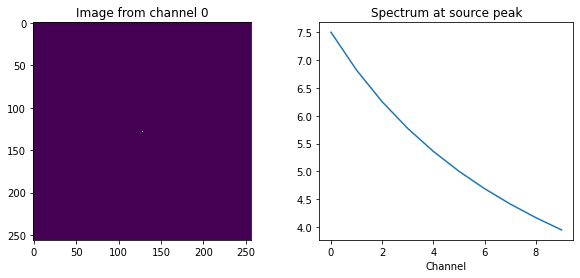

In [13]:
## Make the component list
makeCompList()

## Make an empty CASA image
makeEmptyImage()
## Evaluate the component list onto the CASA image
evalCompList()

## Display
dispImage()

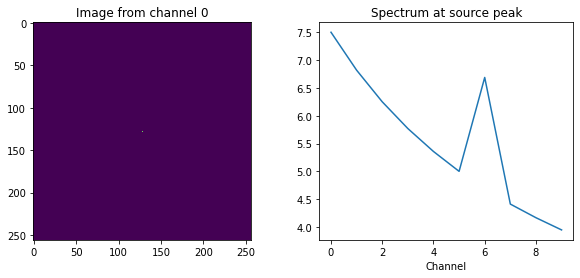

In [14]:
## Edit the pixels of the CASA image directly (e.g. add a spectral line)
editPixels()

## Display
dispImage()

## Simulate visibilities from the sky model into the DATA column of the MS

Simulate visibilities for the true sky model, applying a variety of instrumental effects. This step either evaluates the DFT of a component model, or uses an imaging (de)gridder.  Instrumental effects can be applied either by pre-processing the sky model before 'standard' degridding, or by invoking one of the wide-field imaging gridders to apply W-term, A-term and mosaicing effects. Noise, extra spectral lines or RFI may be added at this point, as well as gain errors via the application of carefully constructed calibration tables. 

__Methods__

__Use the simulator tool__

Visibilities are predicted and saved in the DATA column of the MS.
It is preferable to use the simulator only when the standard gridder is desired. 
Prediction can be done from an input model image or a component list

In [15]:
def predictSim(msname='sim_data.ms',
                imname='sim_onepoint_true.im', 
                clname='sim_onepoint.cl',
                usemod='im',
                usepb=False):
    """
    usemod = 'im' : use the imname image
    usemod = 'cl' : use the clname component list
    usepb = True : to include static primary beams in the simulation.
    """
    ## Open an existing MS Frame
    sm.openfromms(msname)

    # Include primary Beams
    if usepb==True:
        sm.setvp( dovp = True, usedefaultvp = True )

    if usemod=='im':
        # Predict from a model image
        sm.predict( imagename = imname, incremental=False)
    else:
        # Predict from a component list
        sm.predict( complist = clname ,incremental=False)

    # Close the tool
    sm.close()

__Use imager (or ft)__

Visibilities are predicted and saved in the MODEL_DATA column of the MS. The values must then be copied to the DATA column. Use this approach when non-standard gridders are required, typically when instrument-dependent effects are included, or when Taylor-coefficient wideband image models are to be used for visibility prediction.

__Step 1__ : Simulate visibilities into the MODEL column using tclean

tclean can be used for model prediction with all gridders ('standard', 'wproject', 'mosaic', 'awproject'). Wide-field and full-beam effects along with parallactic angle rotation may be included with appropriate settings. tclean can predict model visibilities only from input images and not component lists.

In [16]:
## Use an input model sky image - widefield gridders
def predictImager(msname='sim_data.ms',
                  imname_true='sim_onepoint_true.im',
                  gridder='standard'):
    
    os.system('rm -rf sim_predict.*')
    
    # Run tclean in predictModel mode. 
    tclean(vis=msname,
       startmodel=imname_true,
       imagename='sim_predict',
       savemodel='modelcolumn',
       imsize=256,
       cell='8.0arcsec',
       specmode='cube',
       interpolation='nearest',
       start='1.0GHz',
       width='0.1GHz',
       nchan=10,
       reffreq='1.5Hz',
       gridder=gridder,
       normtype='flatsky',  # sky model is flat-sky
       cfcache='sim_predict.cfcache',
       wbawp=True,      # ensure that gridders='mosaic' and 'awproject' do freq-dep PBs
       pblimit=0.05,    
       conjbeams=False, 
       calcres=False, 
       calcpsf=True, 
       niter=0, 
       wprojplanes=1)

__Step 1__ : Simulate visibilities into the MODEL column using ft 

The 'ft' task implements the equivalent of gridder='standard' in tclean. Wide-field effects cannot be simulated. 

In addition, it offers the ability to predict visibilities from component lists (which tclean does not). 

In [17]:
def predictFt(msname='sim_data.ms',
    imname='sim_onepoint_true.im', 
    clname='sim_onepoint.cl',
    usemod='im'):
    
    if usemod=='im':
        ## Use an image name and the ft task
        ft(vis = msname, model = imname,  incremental = False, usescratch=True) 
    else:
        ## Use a component list and the ft task 
        ft(vis = msname,  complist = clname, incremental = False, usescratch=True)



__Step 2__ : Copy contents of the MODEL column to the DATA column

In [18]:
### Copy visibilities from the MODEL column to the data columns
### This is required when predicting using tclean or ft as they will only write to the MODEL column
def copyModelToData(msname='sim_data.ms'):
    tb.open(msname,nomodify=False);
    moddata = tb.getcol(columnname='MODEL_DATA');
    tb.putcol(columnname='DATA',value=moddata);
    #tb.putcol(columnname='CORRECTED_DATA',value=moddata);
    moddata.fill(0.0);
    tb.putcol(columnname='MODEL_DATA',value=moddata);
    tb.close();

__Examples__

If the above commands were run in order, the component list contains only a steep-spectrum continuum source, but the model image cube contains an additional spectral line in it. 

__Option 1__ : Predict using the simulator and a componentlist

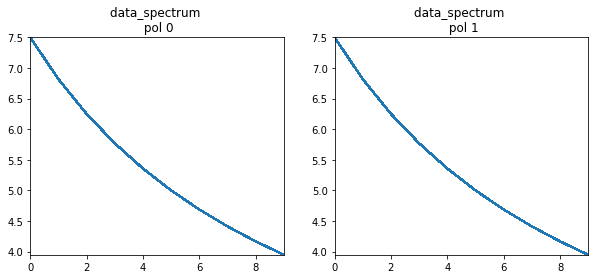

In [19]:
# Predict Visibilities
predictSim(usemod='cl')

# Plot
plotData(myplot='data_spectrum')

__Option 2__ : Predict using the simulator and an input image

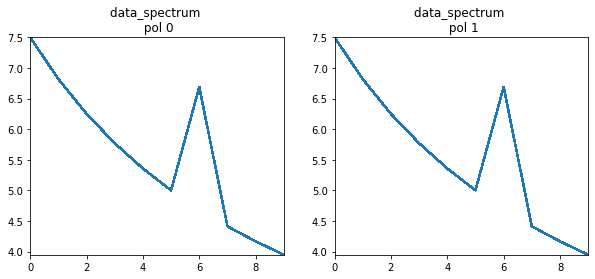

In [20]:
# Predict visibilities
predictSim(usemod='im')

# Plot
plotData(myplot='data_spectrum')

__Option 3__ : Predict using tclean and a model image with gridder='standard'

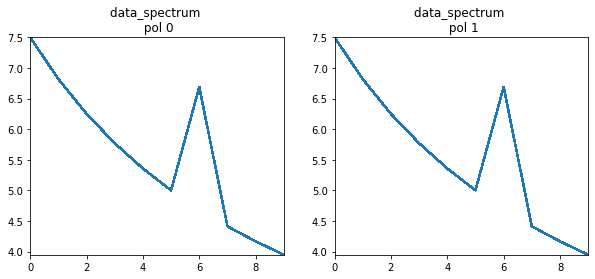

In [21]:
predictImager()
copyModelToData()
plotData(myplot='data_spectrum')

__Option 4__ : Predict using ft and a component list

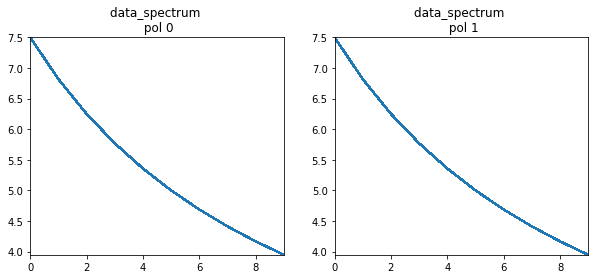

In [22]:
# Predict using ft
predictFt(usemod='cl')
copyModelToData()

# Plot
plotData(myplot='data_spectrum')

__Option 5__ : Predict using ft and an input image

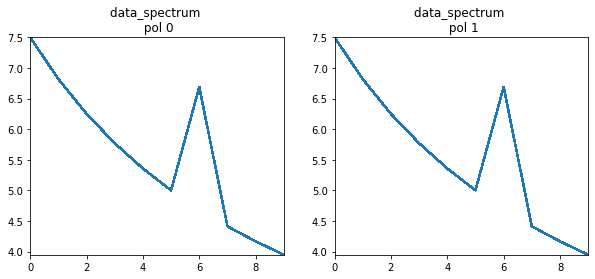

In [23]:
# Predict using ft
predictFt(usemod='im')
copyModelToData()

# Plot
plotData(myplot='data_spectrum')

## Add Noise and other errors to the simulated visibilities

__Methods__

__Add Visibility noise__

In [24]:
## Add Gaussian random noise 
def addNoiseSim(msname='sim_data.ms'):
    sm.openfromms(msname);
    sm.setseed(50)
    sm.setnoise(mode='simplenoise',simplenoise='0.05Jy');
    sm.corrupt();   
    sm.close();

__Add random numbers__

In [25]:
def addNoiseRand(msname = 'sim_data.ms'):
    ## Add noise and other variations
    tb.open( msname, nomodify=False )
    dat = tb.getcol('DATA')
    
    ## Add noise to the first few channels only. ( Ideally, add separately to real and imag parts... )
    from numpy import random
    dat[:,0:4,:] = dat[:,0:4,:] + 0.5 * random.random( dat[:,0:4,:].shape )

    ## Add some RFI in a few rows and channels.... 
    #dat[ :, :, 1 ] = dat[ :, :, 1] + 2.0
    
    tb.putcol( 'DATA', dat )
    tb.close()

__Add antenna gain errors__

In [26]:
## Add antenna gain errors.
def addGainErrors(msname='sim_data.ms'):
    sm.openfromms(msname);
    sm.setseed(50)
    sm.setgain(mode='fbm',amplitude=0.1)
    sm.corrupt()
    sm.close();

## Note : This step sometimes produces NaN/Inf in the visibilities and plotData() will complain ! If so, just run it again. I thought that setting the seed will control this, but apparently not. 

__Examples__

Use the simulator to add Gaussian random noise (1 Jy rms noise)

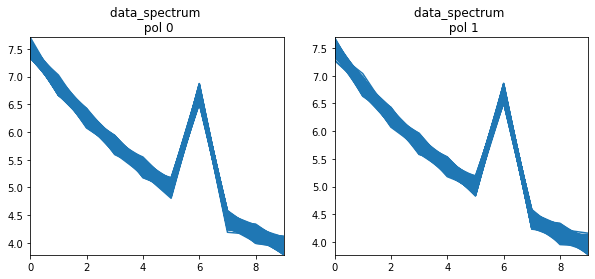

In [27]:
addNoiseSim()
plotData(myplot='data_spectrum')

## A few Imaging and Calibration examples

### Image one channel

In [28]:
# Call tclean
os.system('rm -rf try0.*')

tclean(vis='sim_data.ms', 
       imagename='try0',
       datacolumn='data',
       spw='0:5',          # pick channel 5 and image it
       imsize=300,
       cell='8.0arcsec',
       specmode='mfs',
       gridder='standard',
       niter=200,
       gain=0.3,
       interactive=False,
       usemask='auto-multithresh')


{}

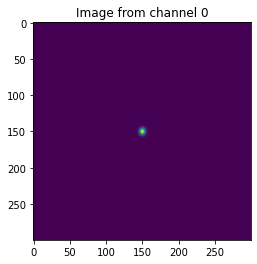

In [29]:
# Display the output restored image
dispImage('try0.image')

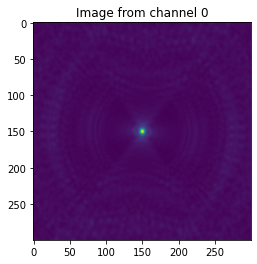

In [30]:
# Display the point spread function
dispImage('try0.psf')

### Cube Imaging of a spectral-line dataset

This is a spectral line dataset with noise

In [31]:
# Call tclean
os.system('rm -rf try1.*')

tclean(vis='sim_data.ms', 
       imagename='try1',
       datacolumn='data',
       imsize=300,
       cell='8.0arcsec',
       specmode='cube',
       interpolation='nearest',
       gridder='standard',
       niter=200,
       gain=0.3,
       savemodel='modelcolumn')

{}

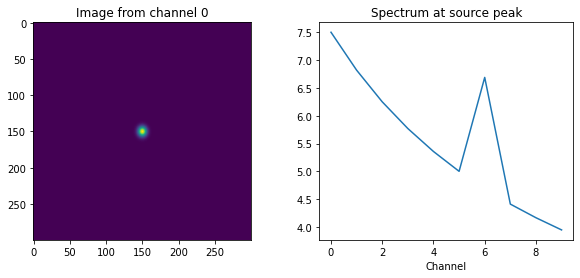

In [32]:
# Display the output restored image
dispImage('try1.image')

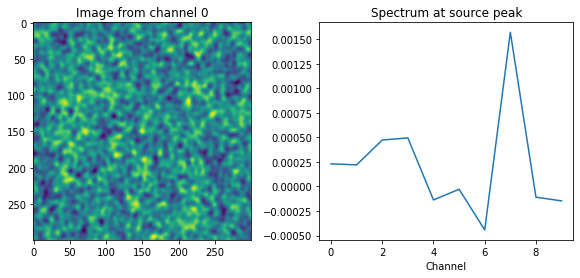

In [33]:
# Display the residual image
dispImage('try1.residual')

### Continuum imaging with model subtraction

Pick the line-free channels (all but chan 6) and fit a 2nd order polynomial to the spectrum.

In [34]:
# Call tclean
os.system('rm -rf try2.*')

tclean(vis='sim_data.ms', 
       imagename='try2',
       datacolumn='data',
       spw='0:0~5,0:7~9', # Select line-free channels
       imsize=300,
       cell='8.0arcsec',
       specmode='mfs',
       deconvolver='mtmfs',
       nterms=3,
       gridder='standard',
       niter=150,
       gain=0.3)

{}

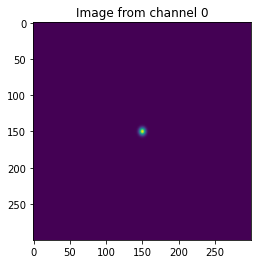

In [35]:
# Display the output restored image
dispImage('try2.image.tt0')

In [36]:
# Predict the tclean mtmfs model onto all channels.
tclean(vis='sim_data.ms', 
       imagename='try2',
       datacolumn='data',
       spw='',    # Select all channels to predict onto.
       imsize=300,
       cell='8.0arcsec',
       specmode='mfs',
       deconvolver='mtmfs',
       nterms=3,
       gridder='standard',
       niter=0,
       calcres=False,
       calcpsf=False,
       savemodel='modelcolumn')

{}

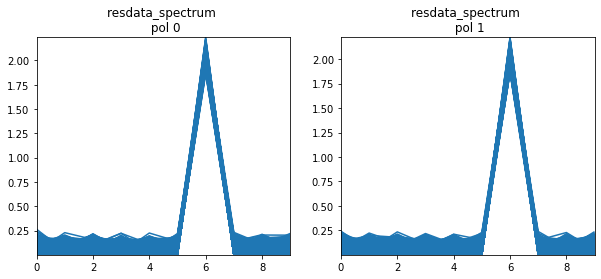

In [37]:
# Plot residual data. 
plotData(myplot='resdata_spectrum')

This shows the continuum power law emission subtracted out and only the spectral line remaining in the data (if the model is subtracted).

If the 'uvsub' task is run, this is what would get saved in corrected_data. It is also a form of continuum modeling and subtraction.

### Imaging with Gain Errors and Self Calibration

First, re-simulate by starting from ideal visibilities, and adding gain errors and noise. 

In [38]:
# Predict visibilities
predictSim(usemod='im')

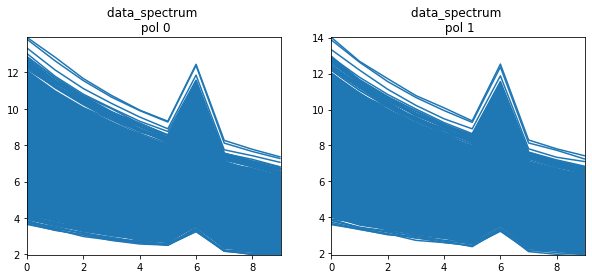

In [39]:
# Simulate antenna gain errors
addGainErrors()
# Add noise on top of the gain-corrupted data
addNoiseSim()
# Display
plotData(myplot='data_spectrum')

Image the corrupted data

In [40]:
# Call tclean
os.system('rm -rf try3.*')

tclean(vis='sim_data.ms', 
       imagename='try3',
       datacolumn='data',
       imsize=300,
       cell='8.0arcsec',
       specmode='cube',
       interpolation='nearest',
       gridder='standard',
       niter=150,         # Don't go too deep since the data are corrupted
       gain=0.3,
       mask='circle[[150pix,150pix],3pix]',    # Give it a mask to help. Without this, the self-cal isn't as good.
       savemodel='modelcolumn')

{}

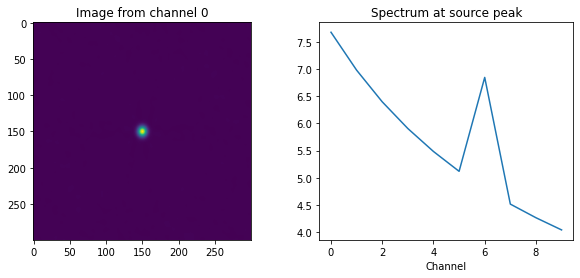

In [41]:
# Display the output restored image
dispImage('try3.image')

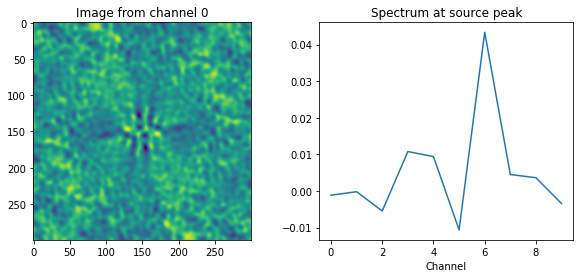

In [42]:
# Display the new residual image
dispImage('try3.residual')

This image shows artifacts from gain errors (different from the pure noise-like errors in the previous simulation)

Calculate gain solutions (since we have already saved the model)

In [43]:
bandpass(vis='sim_data.ms',
        caltable='sc.tab',solint='int')

Apply gain solutions

In [44]:
applycal(vis='sim_data.ms',
        gaintable='sc.tab')

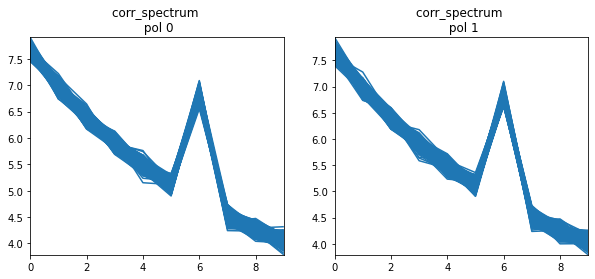

In [45]:
## Plot Calibrated data
plotData(myplot='corr_spectrum')

Compare with the above uncalibrated data. Also, compare with visibilities simulated just with noise. Subsequent imaging should use the corrected_data column.

In [46]:
# Call tclean to image the corrected data
os.system('rm -rf try4.*')

tclean(vis='sim_data.ms', 
       imagename='try4',
       datacolumn='corrected',
       imsize=300,
       cell='8.0arcsec',
       specmode='cube',
       interpolation='nearest',
       gridder='standard',
       niter=200,       # Go deeper now. Also, no mask needed
       gain=0.3,
       savemodel='modelcolumn')

{}

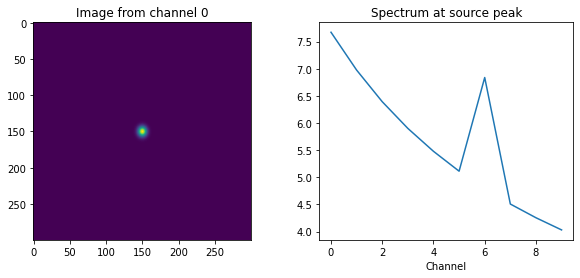

In [47]:
# Display the output restored image
dispImage('try4.image')

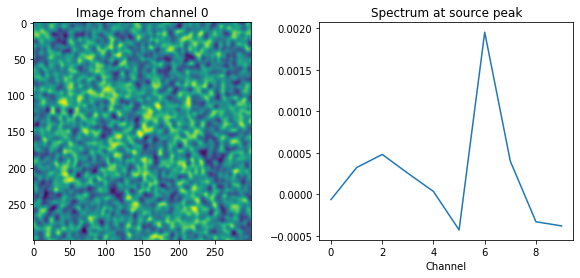

In [48]:
# Display the residual image
dispImage('try4.residual')

A better-looking residual image, compared to before self-calibration. 